In [43]:
import pandas as pd
import datetime
import pymystem3
import pymorphy3
import textdistance
import numpy as np
import re
from collections import Counter
from nltk.stem import SnowballStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud

## Извлечение дат

In [44]:
df = pd.DataFrame(columns=['date', 'weather'])

In [45]:
months = {
    "Января" : "January",
    "Февраля" : "February",
    "Марта" : "March",
    "Апреля" : "April",
    "Мая" : "May",
    "Июня" : "June",
    "Июля" : "July",
    "Августа" : "August",
    "Сентября" : "September",
    "Октября" : "October",
    "Ноября" : "November",
    "Декабря" : "December"
}

def parse_time(s : str) -> list[str]:
    for ru_month in months.keys():
        s = s.replace(ru_month, months[ru_month])
    l = list(s)
    i1 = l.index('[')
    i2 = l.index(' ', i1)
    l[i2] = ':'
    l.remove('[')
    l.remove(']')
    return "".join(l)

print(parse_time('10 Января [11 45]      '))

10 January 11:45      


In [46]:
def extract_date_weather(line : str) -> tuple[datetime.datetime, str]:
    l = line.split('"')
    date_string = parse_time(l[1])
    date = datetime.datetime.strptime(date_string, "%d %B %Y %H:%M")
    return (date, l[3])

In [47]:
weather = {"date" : [], "weather" : []}

In [48]:
with open("data/dataMeteo.txt") as data_file, open("data/dataMeteo_new.txt") as data_file_new:
    for line1, line2 in zip(data_file, data_file_new):
        for l in (line1, line2):
            t = extract_date_weather(l)
            weather['date'].append(t[0])
            weather['weather'].append(t[1])


In [49]:
df = pd.DataFrame(weather)
df.head()

,date,weather
0,2019-04-07 11:45:00,8 апреля в горах Дагестана выше 2500 м в гора...
1,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...
2,2019-04-06 10:55:00,7-9 апреля в горных районах муниципального обр...
3,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...
4,2019-04-06 09:30:00,7 апреля в горах Дагестана выше 2500 м 7-9 ...


## Извлечение названий регионов

In [50]:
mystem = pymystem3.Mystem()
morphy = pymorphy3.MorphAnalyzer()

In [51]:
def lemmatizeSentences(texts):
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 1000)  # Куски по 1000 предложений
    res = []
    # txtp = 1000 предложений
    for txtp in txtpart:
        # Объединяем 1000 предложений
        alltexts = ' '.join([txt + ' br ' for txt in txtp])

        words = mystem.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(" ".join(doc))
                    doc = []
                else:
                    doc.append(txt)
    return res

In [52]:
df['weather_l'] = lemmatizeSentences(df['weather'])

In [53]:
df.head()

,date,weather,weather_l
0,2019-04-07 11:45:00,8 апреля в горах Дагестана выше 2500 м в гора...,8 апрель в гора дагестан высоко 2500 м в гора ...
1,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...
2,2019-04-06 10:55:00,7-9 апреля в горных районах муниципального обр...,7 - 9 апрель в горный район муниципальный обра...
3,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...
4,2019-04-06 09:30:00,7 апреля в горах Дагестана выше 2500 м 7-9 ...,7 апрель в гора дагестан высоко 2500 м 7 - 9 а...


In [54]:
df_towns = pd.read_csv('data/towns.csv')

In [55]:
df_towns.head()

,city,population,lat,lon,region_name,region_name_ao,region_iso_code,federal_district,okato,oktmo,kladr_id,fias_id,place_id
0,Алейск,29.0,52.492251,82.779361,Алтайский край,NaN,RU-ALT,Сибирский,1403000000,1703000001,2200000200000,ae716080-f27b-40b6-a555-cf8b518e849e,257210632.0
1,Барнаул,632.4,53.347997,83.779806,Алтайский край,NaN,RU-ALT,Сибирский,1401000000,1701000001,2200000100000,d13945a8-7017-46ab-b1e6-ede1e89317ad,258390190.0
2,Белокуриха,15.2,51.996152,84.983960,Алтайский край,NaN,RU-ALT,Сибирский,1404000000,1704000001,2200000300000,e4edca96-9b86-4cac-8c7f-cc93d9ba4cd1,258169961.0
3,Бийск,199.5,52.539386,85.213845,Алтайский край,NaN,RU-ALT,Сибирский,1405000000,1705000001,2200000400000,52f876f6-cb1d-4f23-a22f-b692609fc1e0,258937159.0
4,Горняк,12.3,50.997962,81.464336,Алтайский край,NaN,RU-ALT,Сибирский,1225501000,1625101001,2202700100000,094b3627-2699-4782-8492-4d82aac71958,259062368.0


In [56]:
df_regions = pd.read_csv('data/regions.csv')
df_regions.head()

,region
0,Алтайский край
1,Амурская область
2,Архангельская область
3,Астраханская область
4,Белгородская область


In [57]:
class MyStemmer :
    snowball_stemmer = SnowballStemmer("russian")
    def stem(self, s : str) -> str :
        s = self.snowball_stemmer.stem(s)
        if s[-2:] == "ск" :
            s = s[:-2]
        return s

In [58]:
my_stemmer = MyStemmer()
print(my_stemmer.stem("чувашский"), my_stemmer.stem("чувашия"))

чуваш чуваш


In [59]:
stop_words = ["автономная", "автономный", "область", "округ", "край", "республика"] 

In [60]:
def region_transform(s : str, stemmer) :
    s = s.lower()
    for w in stop_words :
        s = s.replace(w, "")
    return stemmer.stem(s.split()[0])

In [61]:
snowball_stemmer = SnowballStemmer("russian")

In [62]:
df_regions['region_stemmed'] = df_regions['region'].map(lambda x : region_transform(x, snowball_stemmer))
df_regions['region_stemmed_full'] = df_regions['region'].map(lambda x : region_transform(x, my_stemmer))
df_regions.head()

,region,region_stemmed,region_stemmed_full
0,Алтайский край,алтайск,алтай
1,Амурская область,амурск,амур
2,Архангельская область,архангельск,архангель
3,Астраханская область,астраханск,астрахан
4,Белгородская область,белгородск,белгород


In [63]:
regions_dict = df_regions['region_stemmed'].to_dict()
regions_dict_full = df_regions['region_stemmed_full'].to_dict()
regions_dict = {v : k for k, v in regions_dict.items()}
regions_dict_full = {v : k for k, v in regions_dict_full.items()}

In [64]:
stem = my_stemmer.stem

print(stem("чувашская"), ":", stem("чувашия"), textdistance.levenshtein(stem("чувашская"), stem("чувашия")), "\n",
    stem("чувашия"), ":", stem("чукотский"), textdistance.levenshtein(stem("чувашия"), stem("чукотский")), "\n",
    stem("чувашский"), ":", stem("чукотcкий"), textdistance.levenshtein(stem("чувашский"), stem("чукотский")), "\n",
    stem("чувашский"), ":", stem("чукотка"),textdistance.levenshtein(stem("чувашский"), stem("чукотка")), "\n",
    stem("карачаево-черкесия"), ":", stem("карачаево-черкесская"), textdistance.levenshtein(stem("карачаево-черкесия"), stem("карачаево-черкесская")))

# print(textdistance.levenshtein(stem("чувашская"), stem("чувашия")), 
#       textdistance.levenshtein(stem("чувашия"), stem("чукотский")), 
#       textdistance.levenshtein(stem("чувашский"), stem("чукотский")),
#       textdistance.levenshtein(stem("чувашский"), stem("чукотка")),
#       textdistance.levenshtein(stem("карачево-черкесия"), stem("карачаево-черкесская")))

чуваш : чуваш 0 
 чуваш : чукот 3 
 чуваш : чукотcк 3 
 чуваш : чукотк 4 
 карачаево-черкес : карачаево-черкес 0


In [65]:
towns_dict = df_towns[['city', 'region_name']]
towns_dict['city'] = towns_dict['city'].transform(lambda x : region_transform(x, snowball_stemmer))
towns_dict['region_name'] = towns_dict['region_name'].map(lambda x : region_transform(x, snowball_stemmer))
towns_dict.set_index('city', inplace=True)
towns_dict = towns_dict.to_dict()['region_name']

/tmp/ipykernel_113707/3195150538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towns_dict['city'] = towns_dict['city'].transform(lambda x : region_transform(x, snowball_stemmer))
/tmp/ipykernel_113707/3195150538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towns_dict['region_name'] = towns_dict['region_name'].map(lambda x : region_transform(x, snowball_stemmer))


In [66]:
def region_match(s : str) -> list :
    matched = set()
    for w in s.split() :
        stem = snowball_stemmer.stem(w)
        stem_full = my_stemmer.stem(w)
        if stem in regions_dict :
            matched.add(regions_dict[stem])
        elif stem_full in regions_dict_full :
            matched.add(regions_dict_full[stem_full])
        elif stem in towns_dict :
            matched.add(regions_dict[towns_dict[stem]])
    return matched
        

In [67]:
forecast1 = df['weather_l'][771]
forecast2 = df['weather_l'][773]
forecast3 = "".join(mystem.lemmatize("Завтра в Новосибирске солнечно, а в Екатеринбурге идут дожди"))
forecast3 = lemmatizeSentences(["Завтра в Новосибирске солнечно, а в Екатеринбурге идут дожди"])[0]
print(forecast1)
matched = region_match(forecast1)
print(matched, [df_regions['region'][i] for i in matched])
print(forecast2)
matched = region_match(forecast2)
print(matched, [df_regions['region'][i] for i in matched])
print(forecast3)
matched = region_match(forecast3)
print(matched, [df_regions['region'][i] for i in matched])

до 15 декабрь 2023 год в омский область и на юг тюменский область сохраняться опасный явление :  аномально холодный погода со среднесуточный температура воздух низкий климатический норма на 10 ° и более .  13 декабрь 2023 год в омский область место сохраняться опасный явление :  сильный мороз с минимальный температура воздух  - 40 ° и низко .
{72, 35} ['Тюменская область', 'Омская область']
в период 12 - 13 декабрь в гора кабардино-балкария ,  карачаево-черкесия ,  северный осетия высоко 2500 м лавиноопасный .
{18, 14, 55} ['Карачаево-Черкесская Республика', 'Кабардино-Балкарская Республика', 'Республика Северная Осетия – Алания']
завтра в новосибирск солнечно ,  а в екатеринбург идти дождь
{65, 34} ['Свердловская область', 'Новосибирская область']


In [68]:
df['region_ids'] = [np.nan] * len(df)
df['region_names'] = [np.nan] * len(df)
df['region_ids'] = df['region_ids'].astype('object')
df['region_names'] = df['region_names'].astype('object')
for i in range(len(df)) :
    matched = region_match(df['weather_l'][i])
    df['region_ids'][i] = list(matched)
    df['region_names'][i] = [df_regions['region'][j] for j in matched]

/tmp/ipykernel_113707/3923328816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region_ids'][i] = list(matched)
/tmp/ipykernel_113707/3923328816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region_names'][i] = [df_regions['region'][j] for j in matched]


In [69]:
df.head()

,date,weather,weather_l,region_ids,region_names
0,2019-04-07 11:45:00,8 апреля в горах Дагестана выше 2500 м в гора...,8 апрель в гора дагестан высоко 2500 м в гора ...,"[43, 46]","[Республика Алтай, Республика Дагестан]"
1,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],[Республика Коми]
2,2019-04-06 10:55:00,7-9 апреля в горных районах муниципального обр...,7 - 9 апрель в горный район муниципальный обра...,[22],[Краснодарский край]
3,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],[Республика Коми]
4,2019-04-06 09:30:00,7 апреля в горах Дагестана выше 2500 м 7-9 ...,7 апрель в гора дагестан высоко 2500 м 7 - 9 а...,"[42, 77, 46, 47, 22]","[Республика Адыгея, Чеченская Республика, Респ..."


## Извлечение погодных явлений

In [70]:
print(morphy.parse("гора")[0].tag)
print(morphy.parse('и')[0].tag)
print(morphy.parse('покров')[0].tag)

NOUN,inan,femn sing,nomn
CONJ
NOUN,inan,masc sing,nomn


In [71]:
nonPunct = re.compile(r'\b[а-яА-Я]+\b')

In [72]:
all_words = dict()
filtered = []
for i in range(len(df)) :
    for w in df['weather_l'][i].split() :
        tag = morphy.parse(w)[0].tag
        stemmed = snowball_stemmer.stem(w)
        if nonPunct.match(w) and 'PREP' not in tag and 'CONJ' not in tag and stemmed not in regions_dict and stemmed not in towns_dict:
            filtered.append(w)
 

In [73]:
word_counts = pd.Series(Counter(filtered))
word_counts.sort_values(inplace=True, ascending=False)

In [74]:
word_counts.head()

ожидаться    7711
м            7285
сильный      7263
ветер        4693
место        4446
dtype: int64

In [75]:
word_list = [w for w in word_counts.index]
wordcloud = WordCloud(width = 2000, height = 2000,
                background_color ='white',
                min_font_size = 10).generate(" ".join(word_list))

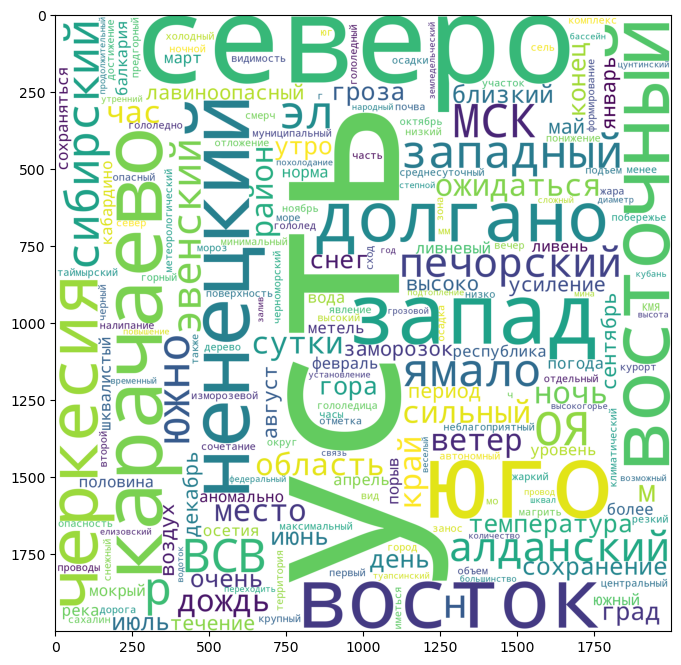

In [76]:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)

In [77]:
word_counts.to_csv('data/word_counts.csv')

In [78]:
weather_ids = pd.read_csv('data/weather_ids.csv', header = None, index_col = 0, squeeze = True)
weather2id = pd.read_csv('data/weather2id.csv', header = None, index_col = 0, squeeze = True)

/tmp/ipykernel_113707/1589329254.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  weather_ids = pd.read_csv('data/weather_ids.csv', header = None, index_col = 0, squeeze = True)
/tmp/ipykernel_113707/1589329254.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  weather2id = pd.read_csv('data/weather2id.csv', header = None, index_col = 0, squeeze = True)


In [79]:
df['conditions_ids'] = [np.nan] * len(df)
df['conditions'] = [np.nan] * len(df)
df['conditions_ids'] = df['conditions_ids'].astype('object')
df['conditions'] = df['conditions_ids'].astype('object')

In [80]:
for i in range(len(df)) :
    condition_ids = set()
    conditions = set()
    for w in df['weather_l'][i].split() :
        if w in weather2id.index :
            condition_ids.add(weather2id[w])
            conditions.add(weather_ids[weather2id[w]])
    df['conditions_ids'][i] = list(condition_ids)
    df['conditions'][i] = list(conditions)

/tmp/ipykernel_113707/2999904912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conditions_ids'][i] = list(condition_ids)
/tmp/ipykernel_113707/2999904912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conditions'][i] = list(conditions)


In [81]:
df[['weather', 'conditions']].to_csv('data/validate.csv')

In [82]:
print(len(df[df['conditions_ids'].apply(lambda x : len(x) > 0)]), len(df))

9959 10380


In [83]:
df.to_csv('data/weather.csv')